### Prompt

Let’s imagine you work on the home team at Spotify. The product designer worked really hard on a new version of the home page, with the hope that it will lead to a higher conversion rate. The product manager told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base.

In [2]:
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats

# estimating statistical models
import statsmodels.stats.api as sms

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


# rounding function
from math import ceil


### Sample Size Calculation

Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [3]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

#                                                         # Effect size for a test comparing two proportions
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1)                                                  # Calculating sample size needed


required_n = ceil(required_n)                          # Rounding up to next whole number
print(required_n)


# required_n = 9999

print(effect_size, required_n)


4720
-0.0576728617308947 4720


### Collecting and preparing the data

- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

In [4]:
df = pd.read_csv('data/ab_data.csv')
print(df.shape)
df.head()


(294399, 5)


,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06,treatment,new_page,0
1,853541,2017-01-08 18:28:03,treatment,new_page,0
2,679687,2017-01-19 3:26:47,treatment,new_page,1
3,817355,2017-01-04 17:58:09,treatment,new_page,1
4,839785,2017-01-15 18:11:07,treatment,new_page,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294399 entries, 0 to 294398
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294399 non-null  int64 
 1   timestamp     294399 non-null  object
 2   group         294399 non-null  object
 3   landing_page  294399 non-null  object
 4   converted     294399 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
first_timestamp_cell = df['timestamp'].iloc[0]

print( first_timestamp_cell, type(first_timestamp_cell), type(pd.to_datetime(first_timestamp_cell)) )

2017-01-11 16:55:06 <class 'str'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


#### Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [7]:
session_counts = df['user_id'].value_counts()
multi_users = session_counts[session_counts > 1].count()

print(multi_users)


3815 user_id
796965    2
649042    2
705774    2
904598    2
826539    2
         ..
699989    1
770290    1
863993    1
883225    1
697314    1
Name: count, Length: 290584, dtype: int64


#### There are 3815 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [9]:
print(df.shape)
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape)

(294399, 5)
(286769, 5)


In [10]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143340
treatment,143429,0


In [11]:
#get rid of users who appeared in the wrong test group

df_control = df[(df['group'] == 'control')].copy()


# Sanity check that everyone in control group didn't receive new page.
df_control = df_control[df.landing_page != 'new_page'].copy()

df_treat = df[(df['group'] == 'treatment')].copy()
df_treat = df_treat[df.landing_page != 'old_page'].copy()

df_clean = pd.concat([df_control, df_treat], ignore_index=True)


df = df_clean.copy()
df.shape

C:\Users\adwal\AppData\Local\Temp\ipykernel_16640\1278853633.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df.landing_page != 'new_page'].copy()
C:\Users\adwal\AppData\Local\Temp\ipykernel_16640\1278853633.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df.landing_page != 'old_page'].copy()


(286769, 5)

In [12]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143340
treatment,143429,0


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=444)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=444)

cont_conv = control_sample.converted.mean()
test_conv = treatment_sample.converted.mean()

print(control_sample,  treatment_sample)
print(cont_conv,  test_conv, "difference: ", test_conv - cont_conv)


        user_id            timestamp    group landing_page  converted
44722    791475  2017-01-21 13:20:59  control     old_page          0
105070   925638  2017-01-08 20:06:39  control     old_page          0
77392    659674  2017-01-13 11:54:00  control     old_page          0
61722    671388   2017-01-03 9:45:23  control     old_page          0
126907   632318  2017-01-06 13:54:02  control     old_page          0
...         ...                  ...      ...          ...        ...
105161   741896  2017-01-16 10:53:21  control     old_page          0
28088    749307   2017-01-08 1:19:39  control     old_page          0
81900    892995   2017-01-16 9:41:59  control     old_page          1
27438    889767   2017-01-15 0:10:53  control     old_page          0
121522   837586  2017-01-21 10:54:36  control     old_page          0

[4720 rows x 5 columns]         user_id            timestamp      group landing_page  converted
286365   882179  2017-01-22 10:51:53  treatment     new_page   

In [15]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,791475,2017-01-21 13:20:59,control,old_page,0
1,925638,2017-01-08 20:06:39,control,old_page,0
2,659674,2017-01-13 11:54:00,control,old_page,0
3,671388,2017-01-03 9:45:23,control,old_page,0
4,632318,2017-01-06 13:54:02,control,old_page,0
...,...,...,...,...,...
9435,663083,2017-01-21 4:43:02,treatment,new_page,0
9436,657358,2017-01-10 3:28:17,treatment,new_page,0
9437,752248,2017-01-14 22:26:13,treatment,new_page,0
9438,872365,2017-01-04 5:49:57,treatment,new_page,0


In [16]:
ab_test['group'].value_counts()


group
control      4720
treatment    4720
Name: count, dtype: int64

### Analysis Visualization

Here are the 13 aggregating functions available in Pandas and quick summary of what it does.

	- mean(): Compute mean of groups
	- sum(): Compute sum of group values
	- size(): Compute group sizes
	- count(): Compute count of group
	- std(): Standard deviation of groups
	- var(): Compute variance of groups
	- sem(): Standard error of the mean of groups
	- describe(): Generates descriptive statistics
	- first(): Compute first of group values
	- last(): Compute last of group values
	- nth() : Take nth value, or a subset if n is a list
	- min(): Compute min of group values
	- max(): Compute max of group values


In [17]:
summary_stats = ab_test.groupby('group')['converted'].agg(['std', 'mean', 'sem', 'sum', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats

,group,std,mean,sem,sum,count
0,control,0.322903,0.118220,0.004700,558,4720
1,treatment,0.351625,0.144492,0.005118,682,4720


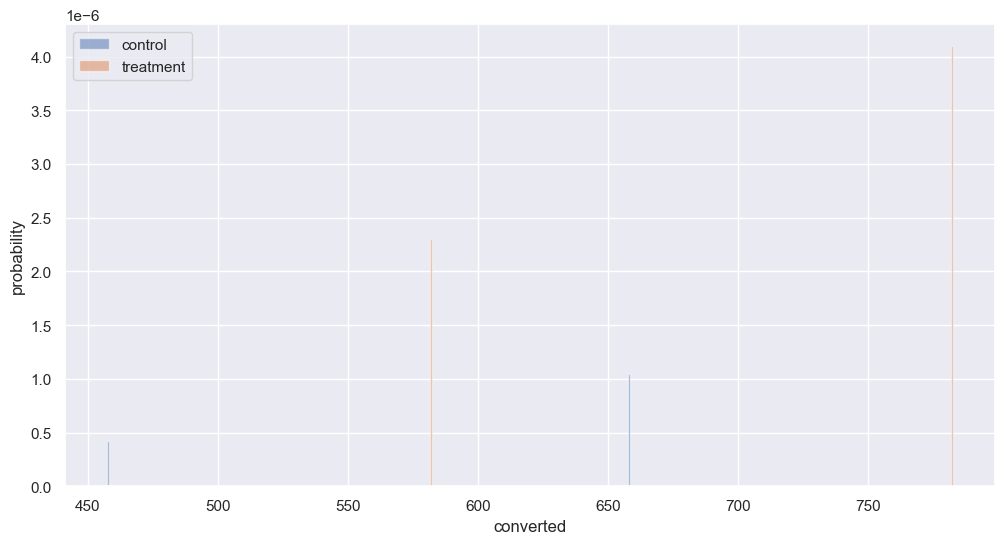

In [26]:
import scipy.stats as scs

control_selector = summary_stats['group'] == 'control'
treatment_selector = summary_stats['group'] == 'treatment'

# number of observations
control_total = summary_stats[control_selector]['count'].values
treatment_total = summary_stats[treatment_selector]['count'].values


# conversion rate
control_cr = summary_stats[ control_selector]['mean'].values
treatment_cr = summary_stats[ treatment_selector]['mean'].values


# total conversions
control_converted = summary_stats[control_selector]['sum'].values
treatment_converted = summary_stats[treatment_selector]['sum'].values


xA = np.linspace(control_converted-100, control_converted+100, 500).flatten()
yA = scs.binom(control_total, control_cr).pmf(xA).flatten()

xB = np.linspace(treatment_converted-100, treatment_converted+100, 500).flatten()
yB = scs.binom(treatment_total, treatment_cr).pmf(xB).flatten()




fig, ax = plt.subplots(figsize=(12,6))
ax.bar(xA, yA, alpha=0.5)
ax.bar(xB, yB, alpha=0.5)


# ax.axvline(x=z.values[0], c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

ax.legend(['control', 'treatment'])

In [23]:
print(control_total, treatment_total)
print(control_cr, treatment_cr)
print(control_converted, treatment_converted)

[4720] [4720]
[0.11822034] [0.14449153]
[558] [682]


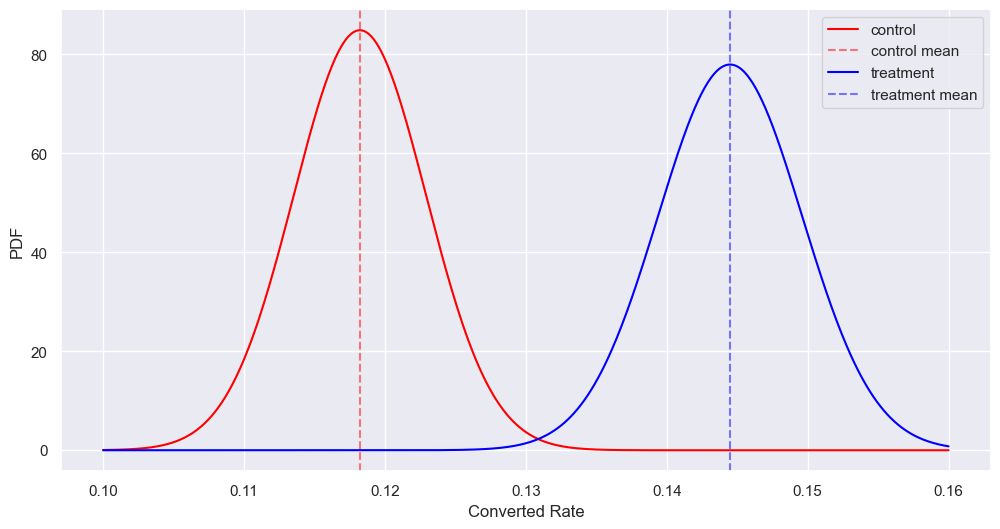

In [36]:
# standard error of the mean for both groups
SE_A = summary_stats[control_selector]['sem']
SE_B = summary_stats[treatment_selector]['sem']


# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(.1, .16, 500)
yA = scs.norm(control_cr, SE_A).pdf(xA)


ax.plot(xA, yA, c='red')
ax.axvline(x=control_cr, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0.1, .16, 500)
yB = scs.norm(treatment_cr, SE_B).pdf(xB)

ax.plot(xB, yB, c='blue')
ax.axvline(x=treatment_cr, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Rate')
plt.ylabel('PDF') #probability density function

ax.legend(labels=['control', 'control mean', 'treatment', 'treatment mean'])

#### Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 11.6% vs. 14.4% conversion rate.


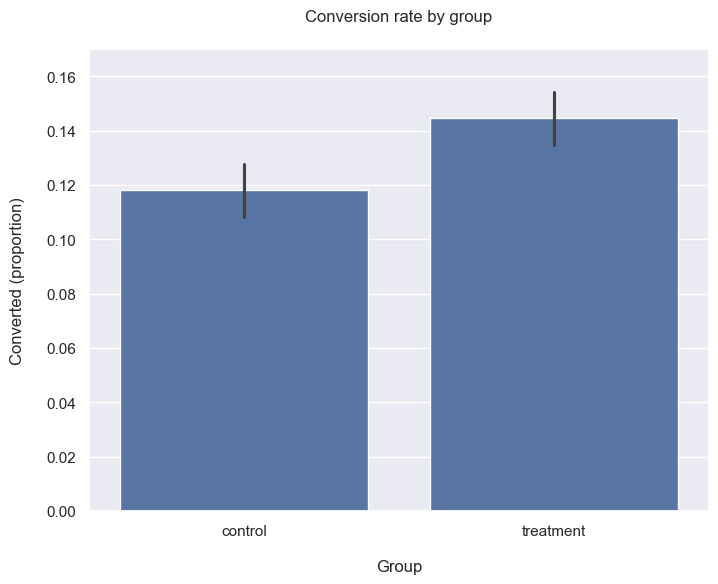

In [44]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'])

plt.ylim(0, 0.17)

plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Testing for Stat Sig

#### Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the p-value and confidence intervals

In [45]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print('observation in control', n_con)
print('observation in treatment', n_treat)
print('successes in control %d, and successes in treatment %d.' % (successes[0], successes[1]))


observation in control 4720
observation in treatment 4720
successes in control 558, and successes in treatment 682.


In [46]:
z_stat, pval = proportions_ztest(
    successes,
    nobs=nobs) #Test for proportions based on normal ztest
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #confidence interval for a binomial proportion


In [47]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.6f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -3.78
p-value: 0.000158
ci 95% for control group: [0.109, 0.127]
ci 95% for treatment group: [0.134, 0.155]


## Since our p-value=0.000158 is WAY below our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new design did  perform significantly better than our old one

In [48]:
summary_stats

,group,std,mean,sem,sum,count
0,control,0.322903,0.118220,0.004700,558,4720
1,treatment,0.351625,0.144492,0.005118,682,4720


#### If we look at the confidence interval for the treatment group ([0.134, 0.154], or 13.4-15.4%) we notice that:
- It does include our target value of 15% (the 2% uplift we were aiming for)

In [49]:
lower_treat, upper_treat

(0.13446130591140723, 0.1545217449360504)

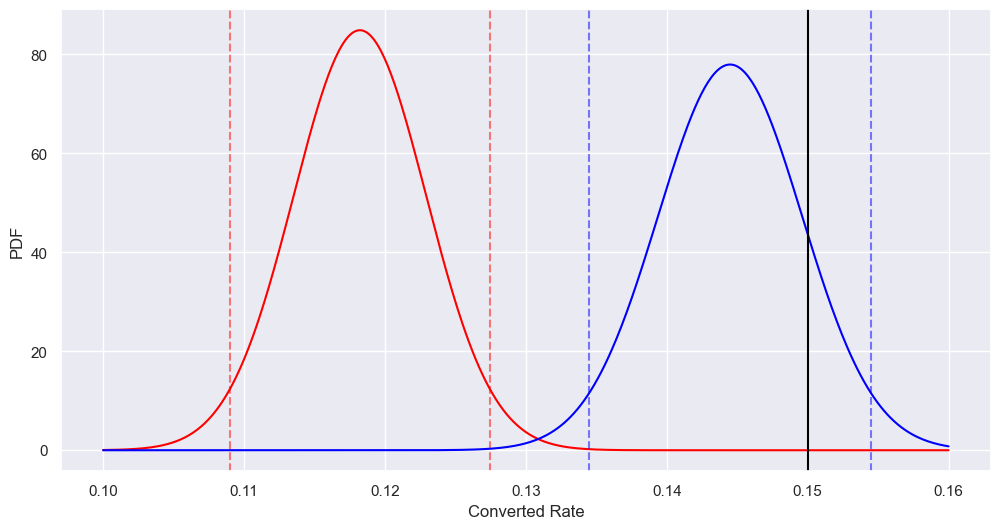

In [50]:

# standard error of the mean for both groups
SE_A = summary_stats[control_selector]['sem']
SE_B = summary_stats[treatment_selector]['sem']


# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(.1, .16, 500)
yA = scs.norm(control_cr, SE_A).pdf(xA)


ax.plot(xA, yA, c='red')

# lower bound
ax.axvline(x=lower_con, c='red', alpha=0.5, linestyle='--')
ax.axvline(x=upper_con, c='red', alpha=0.5, linestyle='--')


xB = np.linspace(0.1, .16, 500)
yB = scs.norm(treatment_cr, SE_B).pdf(xB)
ax.plot(xB, yB, c='blue')

ax.axvline(x=lower_treat, c='blue', alpha=0.5, linestyle='--')
ax.axvline(x=upper_treat, c='blue', alpha=0.5, linestyle='--')


plt.xlabel('Converted Rate')
plt.ylabel('PDF')

ax.axvline(x=0.15, c='black')